In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

#import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy.random as npr
import scipy as sc
import _settings

from tensorflow.examples.tutorials.mnist import input_data

from tensorflow.contrib import slim


In [2]:
tf.set_random_seed = 117

In [3]:
_settings.tf_float = tf.float64
_settings.np_float = np.float64
mnist = input_data.read_data_sets("C:\\Users\\Lewan\\data\\mnist", one_hot=False)


Extracting C:\Users\Lewan\data\mnist\train-images-idx3-ubyte.gz
Extracting C:\Users\Lewan\data\mnist\train-labels-idx1-ubyte.gz
Extracting C:\Users\Lewan\data\mnist\t10k-images-idx3-ubyte.gz
Extracting C:\Users\Lewan\data\mnist\t10k-labels-idx1-ubyte.gz


In [280]:
tf.reset_default_graph()
import svgp
import likelihoods
import transforms
import kernels
from gpflow import settings

class Deep(kernels.Stationary):
    def __init__(self, scope = "kern", input_dim=50, nn = None,  dropout=1.0, ARD=False, lengthscales=None, active_dims=None, name=None):
        super(kernels.Stationary, self).__init__(input_dim, active_dims, name=name)
        self.dropout = dropout
        self.variance_temp = tf.Variable(np.ones(1, _settings.np_float))
#        self.variance = tf.nn.softplus(self.variance_temp)
        self.variance = tf.square(self.variance_temp)
        self.nn = nn
        self.scope = scope
#         if ARD:
#             if lengthscales is None:
#                 lengthscales = np.ones(input_dim, settings.np_float)
#             else:
#                 # accepts float or array:
#                 lengthscales = lengthscales * np.ones(input_dim, settings.np_float)
#             self.lengthscales = tf.Variable(np.square(lengthscales))
#             self.ARD = True
#         else:
#             if lengthscales is None:
#                 lengthscales = 1.0
#             self.lengthscales = tf.Variable(np.square(lengthscales))
#             self.ARD = False
    def square_dist(self, X, X2):
        X = X 
        Xs = tf.reduce_sum(tf.square(X), axis=1)

        if X2 is None:
            dist = -2 * tf.matmul(X, X, transpose_b=True)
            dist += tf.reshape(Xs, (-1, 1))  + tf.reshape(Xs, (1, -1))
            return dist

        X2 = X2 
        X2s = tf.reduce_sum(tf.square(X2), axis=1)
        dist = -2 * tf.matmul(X, X2, transpose_b=True)
        dist += tf.reshape(Xs, (-1, 1)) + tf.reshape(X2s, (1, -1))
        return dist 
    
    def Kdiag(self, X, presliced=False):
        return tf.fill(tf.stack([tf.shape(X)[0]]), tf.squeeze(self.variance))
    
    def deep_kernel(self, x):
        with tf.variable_scope(self.scope, reuse = True):
            return self.nn(x)
    
    def K(self, X, X2=None):
        fX1 = self.deep_kernel(X)
#        fX1 = fX1.astype(tf.float64)
        if X2 is None:
            fX2 = fX1
        else:
            fX2 = self.deep_kernel(X2)
#            fX2.astype(tf.float64)
#        return tf.matmul(self.base_kernel(X), self.base_kernel(X2), transpose_b = True)
        K = self.variance * tf.exp(-self.square_dist(fX1, fX2) / 2)
#        r2 = self.variance * self.square_dist(fX1, fX2)
#        K = tf.sqrt(tf.abs(r2))
    
#          if npr.uniform() < 0.5:
#              D = tf.matrix_band_part(K, 0, 0)
#              U = tf.matrix_band_part(K, 0, -1) - D
#              K = U + D + tf.transpose(U)
#          else:
#              D = tf.matrix_band_part(K, 0, 0)
#              U = tf.matrix_band_part(K, -1, 0) - D
#              K = U + D + tf.transpose(U)
#         K = U + D + tf.transpose(U)
        return K


In [281]:
tf.reset_default_graph()
drop = tf.placeholder(tf.float64)
phase = tf.placeholder(tf.bool)

def NN_BN(x_ph):
    x_ph = tf.cast(x_ph, tf.float32)
    x_ph = tf.reshape(x_ph, [-1,28, 28, 1])
    h = tf.layers.conv2d(x_ph, 32, 3, padding='same', activation=None, trainable=True)
    h = slim.batch_norm(h, center=True, scale=True, is_training=phase)
    h = tf.nn.relu(h)
#    h = tf.layers.dropout(h, drop, training=True)
    h = tf.layers.conv2d(h, 64, 3, padding='same', activation=None, trainable=True)
    h = slim.batch_norm(h, center=True, scale=True, is_training=phase)
    h = tf.nn.relu(h)
    h = tf.reshape(h, [M,-1])
    h = tf.layers.dense(h, 100, activation=None, trainable=True)
    h = slim.batch_norm(h, center=True, scale=True, is_training=phase)
    h = tf.nn.relu(h)
    h = tf.layers.dense(h, 2, activation=None, trainable=True)
    return tf.cast(h, tf.float64)
#    return h

def NN(x_ph):
    x_ph = tf.cast(x_ph, tf.float32)
    x_ph = tf.reshape(x_ph, [-1,28, 28, 1])
    h = tf.layers.conv2d(x_ph, 32, 3, padding='same', activation=None, trainable=True)
    h = tf.nn.relu(h)
    h = tf.layers.conv2d(h, 64, 3, padding='same', activation=None, trainable=True)
    h = tf.nn.relu(h)
    h = tf.reshape(h, [M,-1])
    h = tf.layers.dense(h, 100, activation=None, trainable=True)
    h = tf.nn.relu(h)
    h = tf.layers.dense(h, 2, activation=None, trainable=True)
    return tf.cast(h, tf.float64)

def CNN_BN(x_ph):
    x_ph = tf.cast(x_ph, tf.float32)
    x_ph = tf.reshape(x_ph, [-1,28, 28, 1])
    h = tf.layers.conv2d(x_ph, 32, 3, padding='same', activation=None, trainable=True)
    h = slim.batch_norm(h, center=True, scale=True, is_training=phase)
    h = tf.nn.relu(h)
#    h = tf.layers.dropout(h, drop, training=True)
    h = tf.layers.conv2d(h, 64, 3, padding='same', activation=None, trainable=True)
    h = slim.batch_norm(h, center=True, scale=True, is_training=phase)
    h = tf.nn.relu(h)
    h = tf.reshape(h, [M,-1])
    h = tf.layers.dense(h, 100, activation=None, trainable=True)
    h = slim.batch_norm(h, center=True, scale=True, is_training=phase)
    h = tf.nn.relu(h)
    h = tf.layers.dense(h, 100, activation=None, trainable=True)
    h = slim.batch_norm(h, center=True, scale=True, is_training=phase)
    h = tf.nn.relu(h)
    h = tf.layers.dense(h, 2, activation=None, trainable=True)
    return tf.cast(h, tf.float64)
#    return h

def CNN(x_ph):
    x_ph = tf.cast(x_ph, tf.float32)
    x_ph = tf.reshape(x_ph, [-1,28, 28, 1])
    h = tf.layers.conv2d(x_ph, 32, 3, padding='same', activation=None, trainable=True)
    h = tf.nn.relu(h)
    h = tf.layers.conv2d(h, 64, 3, padding='same', activation=None, trainable=True)
    h = tf.nn.relu(h)
    h = tf.reshape(h, [M,-1])
    h = tf.layers.dense(h, 100, activation=None, trainable=True)
    h = tf.nn.relu(h)
    h = tf.layers.dense(h, 100, activation=None, trainable=True)
    h = tf.nn.relu(h)
    h = tf.layers.dense(h, 2, activation=None, trainable=True)
    return tf.cast(h, tf.float64)

ntest = 500
ntrain = 100000
sess = tf.InteractiveSession()
k = Deep(input_dim=784,nn=NN)
M = batch_size = 32
X_dat, Y_dat = mnist.train.next_batch(ntrain)
X_test, Y_test = mnist.train.next_batch(ntest)
Z = X_dat[0:M,]
X = tf.placeholder(_settings.tf_float, [M,784])
Y = tf.placeholder(_settings.tf_float, [M,1])
with tf.variable_scope("kern"):
    xm = NN(X)

In [6]:
num_iter = 1000

m = svgp.SVGP(X, Y,kern=k,
                   likelihood=likelihoods.Bernoulli(),Z=Z,minibatch_size=M)

_iter = tf.placeholder(tf.int32, shape=None)

decay = tf.maximum(0., 1.-(tf.cast(_iter, tf.float32)/(num_iter)))

opt = tf.train.AdamOptimizer(0.001)
lik = m._build_likelihood()
train = opt.minimize(-lik)

init_op = tf.global_variables_initializer()
sess.run(init_op)


In [7]:
for i in range(num_iter):
    inds = np.random.choice(len(Y_dat), M, replace=False)
    Xs = X_dat[inds,]
    Ys = Y_dat[inds,] % 2
    Ys = np.expand_dims(Ys, 1)
#    print(np.min(sess.run(m.q_sqrt)))
#    print(np.min(sess.run(m.Z)))
#    print(np.min(sess.run(fvar, {X: X_dat, drop: 0.5})))
    sess.run(train, {Y: Ys, X: Xs, drop: 0.5, phase: True, _iter: i})
    if i % (num_iter//10) == 0:
        print(sess.run(lik, {Y: Ys, X: Xs, drop: 0.5, phase: True}))

-31.7644275211
-25.6390435259
-19.2464984971
-15.6019837324
-12.0844452611
-10.1543507465
-9.76409208264
-10.8726706169
-11.1616155178
-9.97941087431


In [277]:
def outlier_minmax(m=m):
    ms,vs = sess.run(m.predict_y(X), {X: X_s, phase: True})
    min_id = np.where(np.abs(preds-0.5) == min( np.abs(preds-0.5)))[0]
    min_id_global = M*i + min_id
    max_id = np.where(np.abs(preds-0.5) == max( np.abs(preds-0.5)))[0]
    max_id_global = M*i + max_id
    print(min_id_global)
    print(np.sqrt(vs[min_id]))
    print(preds[min_id])
    plt.imshow(X_s[min_id].reshape([28,28]), cmap='gray')
    plt.show()
    print(max_id_global)
    print(np.sqrt(vs[max_id]))
    print(preds[max_id])
    plt.imshow(X_s[max_id].reshape([28,28]), cmap='gray')
    plt.show()
    print("While the smallest variance is:" + str(np.where(vs == np.min(vs))[0]))
    print("While the largest variance is:" + str(np.where(vs == np.max(vs))[0]))
    min_pt = X_s[min_id]
    max_pt = X_s[max_id]
    min_pred = preds[min_id]
    max_pred = preds[max_id]
    return min_pt, max_pt, min_pred, max_pred

In [278]:
def sample_test(test_pts, n_iter, m=m):
    N = len(X_dat)
    L = len(test_pts)
    ms = np.zeros([L, n_iter])
    vs = np.zeros([L, n_iter])
    for j in range(n_iter):
#         for k in range(len(test_inds)):
#             random_inds = np.random.choice(np.setdiff1d(list(range(ntest)), test_inds), M - 1, replace=False)
#             inds = np.concatenate([[test_inds[k]], random_inds])
#             Xs = X_test[inds,]
#             m_s,v_s = sess.run(m.predict_y(X), {X: Xs, phase: True})
#             ms[k,j] = m_s[:,0][0]
#             vs[k,j] = v_s[:,0][0]
        random_inds = np.random.choice(np.setdiff1d(list(range(ntest)), test_pts), M - L, replace=False)
        Xs = X_test[random_inds,]
        Xs = np.concatenate([test_pts,Xs])
        m_s,v_s = sess.run(m.predict_y(X), {X: Xs, phase: True})
        ms[:,j] = m_s[:,0][0:L]
        vs[:,j] = v_s[:,0][0:L]
    return ms,vs

In [392]:
j=3
ntrain = 10**(j+1)
M = batch_size = min(100,ntrain//2)
ntest = 20*M
tf.reset_default_graph()
drop = tf.placeholder(tf.float64)
phase = tf.placeholder(tf.bool)

sess = tf.InteractiveSession()
k = Deep(input_dim=784,nn=NN_BN, scope = "kern")
X_dat, Y_dat = mnist.train.next_batch(ntrain)
X_test, Y_test = mnist.train.next_batch(ntest)
Z = X_dat[0:M,]
X = tf.placeholder(_settings.tf_float, [M,784])
Y = tf.placeholder(_settings.tf_float, [M,1])

with tf.variable_scope(k.scope):
    xm = NN_BN(X)

num_iter = 5000

m = svgp.SVGP(X, Y,kern=k,
                   likelihood=likelihoods.Bernoulli(),Z=Z,minibatch_size=M)

_iter = tf.placeholder(tf.int32, shape=None)

decay = tf.maximum(0., 1.-(tf.cast(_iter, tf.float32)/(num_iter)))

opt = tf.train.AdamOptimizer(0.001)
lik = m._build_likelihood()
train = opt.minimize(-lik)


k = Deep(input_dim=784,nn=NN,scope="kern2")
X_dat, Y_dat = mnist.train.next_batch(ntrain)
X_test, Y_test = mnist.train.next_batch(ntest)
Z = X_dat[0:M,]

with tf.variable_scope(k.scope):
    xm = NN(X)

m2 = svgp.SVGP(X, Y,kern=k,
                   likelihood=likelihoods.Bernoulli(),Z=Z,minibatch_size=M)

lik2 = m2._build_likelihood()
train2 = opt.minimize(-lik2)


## CNN

Y_dat2  =  np.expand_dims(Y_dat%2,1)
b = np.zeros((len(Y_dat), 2))
b[np.arange(len(Y_dat)), Y_dat%2] = 1
Y_dat2 = b

data = tf.placeholder(tf.float32, [batch_size, 784])
target = tf.placeholder(tf.float32, [batch_size, 2])


logit3 = CNN_BN(data)

prediction3 = tf.nn.softmax(logit3)

loss3 = tf.losses.softmax_cross_entropy(target, logit3)

opt = tf.train.AdamOptimizer()

train3 = opt.minimize(loss3)



logit4 = CNN(data)

prediction4 = tf.nn.softmax(logit4)

loss4 = tf.losses.softmax_cross_entropy(target, logit4)

opt = tf.train.AdamOptimizer()

train4 = opt.minimize(loss4)

rng = npr.choice(ntrain,batch_size,replace=False)
data_batch = X_dat[rng, ].astype(np.float32)
target_batch = Y_dat2[rng, ].astype(np.float32) 

init_op = tf.global_variables_initializer()
sess.run(init_op)


for i in range(num_iter):
    inds = np.random.choice(len(Y_dat), M, replace=False)
    Xs = X_dat[inds,]
    Ys = Y_dat[inds,] % 2
    Ys = np.expand_dims(Ys, 1)
#    print(np.min(sess.run(m.q_sqrt)))
#    print(np.min(sess.run(m.Z)))
#    print(np.min(sess.run(fvar, {X: X_dat, drop: 0.5})))
    sess.run(train, {Y: Ys, X: Xs, drop: 0.5, phase: True, _iter: i})
    if i % (num_iter//10) == 0:
        print(sess.run(lik, {Y: Ys, X: Xs, drop: 0.5, phase: True}))
    results = []
for i in range(ntest//batch_size):
    X_s = X_test[M*i:(i+1)*M]
    preds = sess.run(m.predict_y(X), {X: X_s, phase: True})[0]
    actuals = Y_test[batch_size*i:(i+1)*batch_size,] % 2
    #result = np.mean((preds.T - actuals)**2)
    result = np.mean((np.array([preds.T > 0.5]).astype(np.int8) - actuals)**2)
    results = results + [result]
[np.mean(results)]

-99.1319110926
-26.5067852113
-7.32617440874
-6.10780703859
-5.64506781802
-6.43116561643
-4.79256318877
-4.45825044434
-4.21491563283
-4.02412198467


[0.015500000000000003]

In [429]:
def make_image(data):
    fig = plt.imshow(data, cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show(fig)

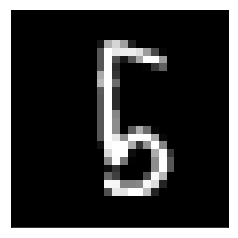

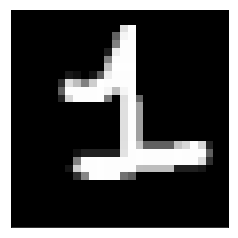

In [431]:
make_image(min_pt.reshape([28,28]))
make_image(min_pt2.reshape([28,28]))

[1904]
[[ 0.49802743]]
[[ 0.54437004]]


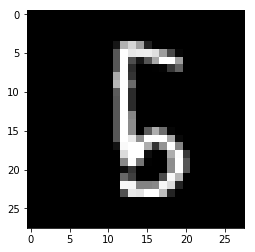

[1978]
[[ 0.06580906]]
[[ 0.00434974]]


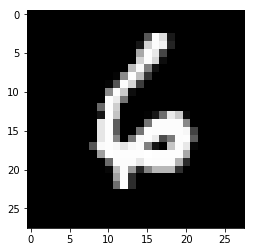

While the smallest variance is:[78]
While the largest variance is:[4]


In [393]:
min_pt,max_pt,min_pred,max_pred = outlier_minmax(m=m)

In [394]:
ms,vs = sample_test(np.concatenate([min_pt,max_pt]),10,m=m)

In [395]:
np.mean(ms,1)

array([ 0.65627991,  0.00563151])

In [396]:
np.mean(vs,1)

array([ 0.2121465 ,  0.00559671])

In [397]:
np.mean(vs + ms**2,1)- 0.01*(np.sum(ms,1))**2

array([ 0.22557659,  0.00559979])

In [398]:


for i in range(num_iter):
    inds = np.random.choice(len(Y_dat), M, replace=False)
    Xs = X_dat[inds,]
    Ys = Y_dat[inds,] % 2
    Ys = np.expand_dims(Ys, 1)
#    print(np.min(sess.run(m.q_sqrt)))
#    print(np.min(sess.run(m.Z)))
#    print(np.min(sess.run(fvar, {X: X_dat, drop: 0.5})))
    sess.run(train2, {Y: Ys, X: Xs, drop: 0.5, phase: True, _iter: i})
    if i % (num_iter//10) == 0:
        print(sess.run(lik2, {Y: Ys, X: Xs, drop: 0.5, phase: True}))
    results = []
for i in range(ntest//batch_size):
    X_s = X_test[M*i:(i+1)*M]
    preds = sess.run(m2.predict_y(X), {X: X_s, phase: True})[0]
    actuals = Y_test[batch_size*i:(i+1)*batch_size,] % 2
    #result = np.mean((preds.T - actuals)**2)
    result = np.mean((np.array([preds.T > 0.5]).astype(np.int8) - actuals)**2)
    results = results + [result]
[np.mean(results)]

-98.9962148685
-8.63145697075
-6.77014852252
-5.66479683346
-5.08149259407
-4.56196088479
-4.20556841508
-3.94212584859
-3.74695591514
-3.60229053523


[0.015500000000000003]

[1940]
[[ 0.49996928]]
[[ 0.49445792]]


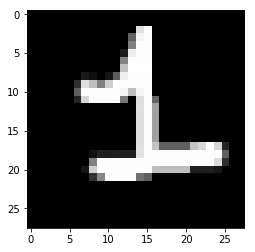

[1987]
[[ 0.06124704]]
[[ 0.99623462]]


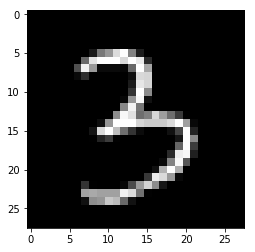

While the smallest variance is:[87]
While the largest variance is:[40]


In [399]:
min_pt2,max_pt2,min_pred2,max_pred2 = outlier_minmax(m=m2)

In [400]:
for i in range(num_iter):
    rng = npr.choice(len(X_dat),batch_size,replace=False)
    data_batch = X_dat[rng, ].astype(np.float32)
    target_batch = Y_dat2[rng, ].astype(np.float32) 
    sess.run(train3, {data: data_batch, target: target_batch, phase: True})
    if i % (num_iter//10) == 0:
        print(sess.run(loss3, {data: data_batch, target: target_batch, phase: True}))
    
results = []
for i in range(ntest//batch_size):
    Xs = X_test[M*i:(i+1)*M]
    preds = sess.run(1/(1+tf.exp(-logit3)),{data: Xs, phase: True})[:,1]
    actuals = Y_test[batch_size*i:(i+1)*batch_size,] % 2
    #result = np.mean((preds - actuals)**2)
    result = np.mean((np.array([preds > 0.5]).astype(np.int8) - actuals)**2)
    results = results + [result]
print([np.mean(results)])

for i in range(num_iter):
    rng = npr.choice(len(X_dat),batch_size,replace=False)
    data_batch = X_dat[rng, ].astype(np.float32)
    target_batch = Y_dat2[rng, ].astype(np.float32) 
    sess.run(train4, {data: data_batch, target: target_batch, phase: True})
    if i % (num_iter//10) == 0:
        print(sess.run(loss4, {data: data_batch, target: target_batch, phase: True}))

0.34348449111
0.00232523004524
0.00368496892042
0.00113458698615
0.000311787880491
0.000202521405299
8.94661643542e-05
4.52453132311e-05
2.05346168514e-05
1.13794658319e-05
[0.016000000000000004]
0.600943803787
0.000374194351025
1.4032535546e-05
0.000123241901747
1.24880500607e-06
3.06357424051e-06
3.4861786844e-06
1.28114299969e-06
1.09798247649e-06
1.11756958177e-06


In [401]:
results = []
for i in range(ntest//batch_size):
    Xs = X_test[M*i:(i+1)*M]
    preds = sess.run(1/(1+tf.exp(-logit4)),{data: Xs, phase: True})[:,1]
    actuals = Y_test[batch_size*i:(i+1)*batch_size,] % 2
    #result = np.mean((preds - actuals)**2)
    result = np.mean((np.array([preds > 0.5]).astype(np.int8) - actuals)**2)
    results = results + [result]
print([np.mean(results)])

[0.017500000000000005]


In [402]:
ms_12,vs_12 = sample_test(np.concatenate([min_pt,max_pt]),1,m=m2)

In [403]:
ms_12

array([[ 0.73272738],
       [ 0.0062941 ]])

In [404]:
vs_12

array([[ 0.19583796],
       [ 0.00625448]])

In [405]:
ms_21, vs_21 = sample_test(np.concatenate([min_pt2,max_pt2]),10,m=m)

In [406]:
np.mean(ms_21,1)

array([ 0.91735079,  0.99297136])

In [407]:
np.mean(vs_21,1)

array([ 0.06954806,  0.0069772 ])

In [408]:
np.mean(vs_21 + ms_21**2,1)- 0.01*(np.sum(ms_21,1))**2

array([ 0.07581832,  0.00697924])

[ 0.51348574]


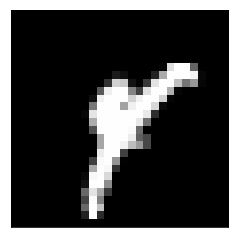

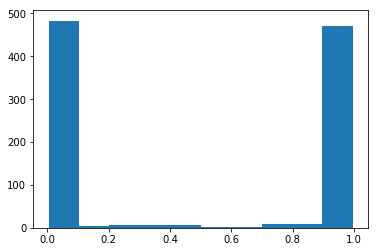

In [494]:
all_preds = np.array([])
inds = np.array([])

for i in range(10):
    random_inds = np.random.choice(list(range(ntest)), M )
    X_s = X_test[random_inds]
    preds = sess.run(m.predict_y(X), {X: X_s, phase: True})[0][:,0]
    all_preds = np.concatenate([all_preds, preds])
    inds = np.concatenate([inds,random_inds])
ind=np.where(np.abs(all_preds-0.5) == min( np.abs(all_preds-0.5)))[0]
print(all_preds[ind])
ind = inds[ind]
indd = ind.astype(np.int)[0]
make_image(X_test[indd].reshape(28,28))
plt.hist(all_preds,10)
plt.show()

[ 0.50183405]


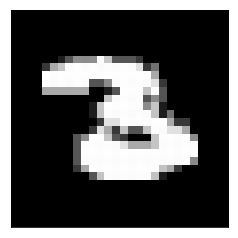

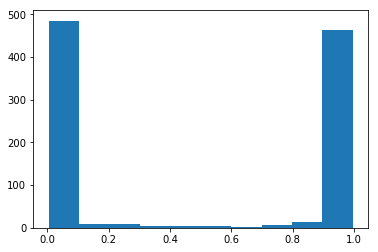

In [495]:
all_preds = np.array([])
inds = np.array([])

for i in range(10):
    random_inds = np.random.choice(list(range(ntest)), M )
    X_s = X_test[random_inds]
    preds = sess.run(m2.predict_y(X), {X: X_s, phase: True})[0][:,0]
    all_preds = np.concatenate([all_preds, preds])
    inds = np.concatenate([inds,random_inds])
ind=np.where(np.abs(all_preds-0.5) == min( np.abs(all_preds-0.5)))[0]
print(all_preds[ind])
ind = inds[ind]
indd = ind.astype(np.int)[0]
make_image(X_test[indd].reshape(28,28))
plt.hist(all_preds,10)
plt.show()

[ 0.49087539]


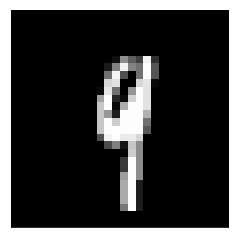

In [481]:
all_preds = np.array([])
inds = np.array([])

for j in range(10):
    random_inds = np.random.choice(list(range(ntest)), M )
    Xs = X_test[random_inds]
    preds = sess.run(1/(1+tf.exp(-logit3)),{data: Xs, phase: True})[:,1]
    all_preds = np.concatenate([all_preds, preds])
    inds = np.concatenate([inds,random_inds])
ind=np.where(np.abs(all_preds-0.5) == min( np.abs(all_preds-0.5)))[0]
print(all_preds[ind])
ind = inds[ind]
indd = ind.astype(np.int)[0]
make_image(X_test[indd].reshape(28,28))
plt.hist(all_preds,10)
plt.show()

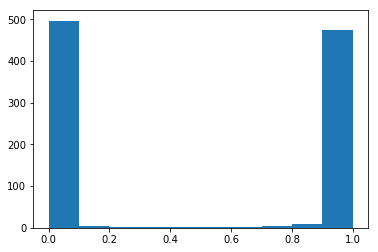

In [482]:
plt.hist(all_preds,10)
plt.show()

[ 0.36120946  0.36120946]


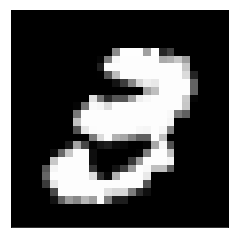

In [483]:
all_preds = np.array([])
inds = np.array([])

for j in range(10):
    random_inds = np.random.choice(list(range(ntest)), M )
    Xs = X_test[random_inds]
    preds = sess.run(1/(1+tf.exp(-logit4)),{data: Xs, phase: True})[:,1]
    all_preds = np.concatenate([all_preds, preds])
    inds = np.concatenate([inds,random_inds])
ind=np.where(np.abs(all_preds-0.5) == min( np.abs(all_preds-0.5)))[0]
print(all_preds[ind])
ind = inds[ind]
indd = ind.astype(np.int)[0]
make_image(X_test[indd].reshape(28,28))

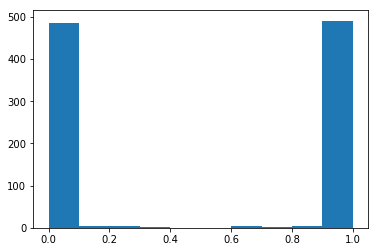

In [484]:
plt.hist(all_preds,10)
plt.show()

In [413]:
n_iter = 50
L = 2
predictions13 = np.zeros([L, n_iter])
for j in range(n_iter):
    random_inds = np.random.choice(list(range(ntest)), M - 2)
    Xs = X_test[random_inds]
    Xs = np.concatenate([np.squeeze(np.array([min_pt,max_pt])),Xs])
    preds = sess.run(1/(1+tf.exp(-logit3)),{data: Xs, phase: True})[:,1]
    result = preds[0:2]
    predictions13[:,j] = result
print(np.mean(predictions13,1))
print(np.var(predictions13,1))

[ 0.82143424  0.00224674]
[  1.19109263e-02   4.02164196e-06]


In [414]:
n_iter = 50
L = 2
predictions14 = np.zeros([L, n_iter])
for j in range(n_iter):
    random_inds = np.random.choice(list(range(ntest)), M - 2)
    Xs = X_test[random_inds]
    Xs = np.concatenate([np.squeeze(np.array([min_pt,max_pt])),Xs])
    preds = sess.run(1/(1+tf.exp(-logit4)),{data: Xs, phase: True})[:,1]
    result = preds[0:2]
    predictions14[:,j] = result
print(np.mean(predictions14,1))
print(np.var(predictions14,1))

[  3.51625850e-03   9.66107756e-06]
[  1.88079096e-37   0.00000000e+00]


In [415]:
n_iter = 50
L = 2
predictions23 = np.zeros([L, n_iter])
for j in range(n_iter):
    random_inds = np.random.choice(list(range(ntest)), M - 2)
    Xs = X_test[random_inds]
    Xs = np.concatenate([np.squeeze(np.array([min_pt2,max_pt2])),Xs])
    preds = sess.run(1/(1+tf.exp(-logit3)),{data: Xs, phase: True})[:,1]
    result = preds[0:2]
    predictions23[:,j] = result
print(np.mean(predictions23,1))
print(np.var(predictions23,1))

[ 0.85708826  0.99320135]
[  1.53971605e-02   7.26447036e-05]


In [416]:
n_iter = 50
L = 2
predictions24 = np.zeros([L, n_iter])
for j in range(n_iter):
    random_inds = np.random.choice(list(range(ntest)), M - 2)
    Xs = X_test[random_inds]
    Xs = np.concatenate([np.squeeze(np.array([min_pt2,max_pt2])),Xs])
    preds = sess.run(1/(1+tf.exp(-logit4)),{data: Xs, phase: True})[:,1]
    result = preds[0:2]
    predictions24[:,j] = result
print(np.mean(predictions24,1))
print(np.var(predictions24,1))

[ 0.99935889  0.99999888]
[  1.23259516e-32   0.00000000e+00]


In [ ]:
final_results_bn = []
final_results_no_bn = []
final_results_dnn_bn = []
final_results_dnn_no_bn = []

In [506]:
results = []
for i in range(ntest//batch_size):
    X_s = X_test[M*i:(i+1)*M]
    preds = sess.run(m.predict_y(X), {X: X_s, phase: True})[0]
    actuals = Y_test[batch_size*i:(i+1)*batch_size,] % 2
    #result = np.mean((preds.T - actuals)**2)
    result = np.mean((np.array([preds.T > 0.5]).astype(np.int8) - actuals)**2)
    results = results + [result]
[np.mean(results)]
results = []
for i in range(ntest//batch_size):
    X_s = X_test[M*i:(i+1)*M]
    preds = sess.run(m.predict_y(X), {X: X_s, phase: True})[0]
    actuals = Y_test[batch_size*i:(i+1)*batch_size,] % 2
    #result = np.mean((preds.T - actuals)**2)
    result = np.mean((np.array([preds.T > 0.5]).astype(np.int8) - actuals)**2)
    results = results + [result]
[np.mean(results)]

ValueError: Input graph and Layer graph are not the same: Tensor("Reshape_256:0", shape=(32, 28, 28, 1), dtype=float32) is not from the passed-in graph.

In [518]:
rng.shape

(100,)

In [527]:
for j in range(5): 
    
    ntrain = 10**(j+5)
    M = batch_size = min(100,ntrain//2)
    ntest = 20*M
    tf.reset_default_graph()
    drop = tf.placeholder(tf.float64)
    phase = tf.placeholder(tf.bool)

    sess = tf.InteractiveSession()
    k = Deep(input_dim=784,nn=NN_BN)
    X_dat, Y_dat = mnist.train.next_batch(ntrain)
    X_test, Y_test = mnist.train.next_batch(ntest)
    Z = X_dat[0:M,]
    X = tf.placeholder(_settings.tf_float, [M,784])
    Y = tf.placeholder(_settings.tf_float, [M,1])

    with tf.variable_scope("kern"):
        xm = NN_BN(X)

    num_iter = 5000

    m = svgp.SVGP(X, Y,kern=k,
                       likelihood=likelihoods.Bernoulli(),Z=Z,minibatch_size=M)

    _iter = tf.placeholder(tf.int32, shape=None)

    decay = tf.maximum(0., 1.-(tf.cast(_iter, tf.float32)/(num_iter)))

    opt = tf.train.AdamOptimizer(0.001)
    lik = m._build_likelihood()
    train = opt.minimize(-lik)

    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    for i in range(num_iter):
        inds = np.random.choice(len(X_dat), M, replace=False)
        Xs = X_dat[inds,]
        Ys = Y_dat[inds,] % 2
        Ys = np.expand_dims(Ys, 1)
    #    print(np.min(sess.run(m.q_sqrt)))
    #    print(np.min(sess.run(m.Z)))
    #    print(np.min(sess.run(fvar, {X: X_dat, drop: 0.5})))
        sess.run(train, {Y: Ys, X: Xs, drop: 0.5, phase: True, _iter: i})
        if i % (num_iter//10) == 0:
            print(sess.run(lik, {Y: Ys, X: Xs, drop: 0.5, phase: True}))
        results = []
    for i in range(ntest//batch_size):
        rng = npr.choice(len(range(ntest)),batch_size,replace=False)
        Xs = X_test[rng, ].astype(np.float32)
        preds = sess.run(m.predict_y(X), {X: Xs, phase: True})[0]
        actuals = Y_test[rng,] % 2
        #result = np.mean((preds.T - actuals)**2)
        result = np.mean((np.array([preds.T > 0.5]).astype(np.int8) - actuals)**2)
        results = results + [result]
    
    final_results_bn = final_results_bn + [np.mean(results)]
    tf.reset_default_graph()
    drop = tf.placeholder(tf.float64)
    phase = tf.placeholder(tf.bool)

    sess = tf.InteractiveSession()
    k = Deep(input_dim=784,nn=NN)
    M = batch_size = min(32,ntrain//2)
    X_dat, Y_dat = mnist.train.next_batch(ntrain)
    X_test, Y_test = mnist.train.next_batch(ntest)
    Z = X_dat[0:M,]
    X = tf.placeholder(_settings.tf_float, [M,784])
    Y = tf.placeholder(_settings.tf_float, [M,1])
    with tf.variable_scope("kern"):
        xm = NN(X)

    num_iter = 5000

    m = svgp.SVGP(X, Y,kern=k,
                       likelihood=likelihoods.Bernoulli(),Z=Z,minibatch_size=M)

    _iter = tf.placeholder(tf.int32, shape=None)

    decay = tf.maximum(0., 1.-(tf.cast(_iter, tf.float32)/(num_iter)))

    opt = tf.train.AdamOptimizer(0.001)
    lik = m._build_likelihood()
    train = opt.minimize(-lik)

    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    for i in range(num_iter):
        inds = np.random.choice(len(X_dat), M, replace=False)
        Xs = X_dat[inds,]
        Ys = Y_dat[inds,] % 2
        Ys = np.expand_dims(Ys, 1)
    #    print(np.min(sess.run(m.q_sqrt)))
    #    print(np.min(sess.run(m.Z)))
    #    print(np.min(sess.run(fvar, {X: X_dat, drop: 0.5})))
        sess.run(train, {Y: Ys, X: Xs, drop: 0.5, phase: True, _iter: i})
        if i % (num_iter//10) == 0:
            print(sess.run(lik, {Y: Ys, X: Xs, drop: 0.5, phase: True}))
        results = []
    for i in range(ntest//batch_size):
        rng = npr.choice(len(range(ntest)),batch_size,replace=False)
        Xs = X_test[rng, ].astype(np.float32)
        preds = sess.run(m.predict_y(X), {X: Xs, phase: True})[0]
        actuals = Y_test[rng,] % 2
        #result = np.mean((preds.T - actuals)**2)
        result = np.mean((np.array([preds.T > 0.5]).astype(np.int8) - actuals)**2)
        results = results + [result]
    final_results_no_bn =  final_results_no_bn + [np.mean(results)]
    Y_dat2  =  np.expand_dims(Y_dat%2,1)
    b = np.zeros((len(Y_dat), 2))
    b[np.arange(len(Y_dat)), Y_dat%2] = 1
    Y_dat2 = b
    tf.reset_default_graph()

    data = tf.placeholder(tf.float32, [batch_size, 784])
    target = tf.placeholder(tf.float32, [batch_size, 2])
    phase = tf.placeholder(tf.bool)


    logit = CNN_BN(data)

    prediction = tf.nn.softmax(logit)

    loss = tf.losses.softmax_cross_entropy(target, logit)

    opt = tf.train.AdamOptimizer()

    train = opt.minimize(loss)

    sess = tf.Session()

    init_op = tf.global_variables_initializer()
    sess.run(init_op)

    for i in range(num_iter):
        rng = npr.choice(len(X_dat),batch_size,replace=False)
        data_batch = X_dat[rng, ].astype(np.float32)
        target_batch = Y_dat2[rng, ].astype(np.float32) 
        sess.run(train, {data: data_batch, target: target_batch, phase: True})
        if i % (num_iter//10) == 0:
            init = lik
            lik = sess.run(loss, {data: data_batch, target: target_batch, phase: True})
            print(lik)
            
    results = []
    for i in range(ntest//batch_size):
        rng = npr.choice(len(range(ntest)),batch_size,replace=False)
        Xs = X_test[rng, ].astype(np.float32)
        preds = sess.run(1/(1+tf.exp(-logit)),{data: Xs, phase: True})[:,1]
        actuals = Y_test[rng,] % 2
        #result = np.mean((preds - actuals)**2)
        result = np.mean((np.array([preds > 0.5]).astype(np.int8) - actuals)**2)
        results = results + [result]
    final_results_dnn_bn = final_results_dnn_bn + [np.mean(results)]
    
    tf.reset_default_graph()

    data = tf.placeholder(tf.float32, [batch_size, 784])
    target = tf.placeholder(tf.float32, [batch_size, 2])
    phase = tf.placeholder(tf.bool)


    logit = CNN(data)

    prediction = tf.nn.softmax(logit)

    loss = tf.losses.softmax_cross_entropy(target, logit)

    opt = tf.train.AdamOptimizer()

    train = opt.minimize(loss)

    sess = tf.Session()

    init_op = tf.global_variables_initializer()
    sess.run(init_op)

    for i in range(num_iter):
        rng = npr.choice(len(X_dat),batch_size,replace=False)
        data_batch = X_dat[rng, ].astype(np.float32)
        target_batch = Y_dat2[rng, ].astype(np.float32) 
        sess.run(train, {data: data_batch, target: target_batch, phase: True})
        if i % (num_iter//10) == 0:
            init = lik
            lik = sess.run(loss, {data: data_batch, target: target_batch, phase: True})
            print(lik)
            
    results = []
    for i in range(ntest//batch_size):
        rng = npr.choice(len(range(ntest)),batch_size,replace=False)
        Xs = X_test[rng, ].astype(np.float32)
        preds = sess.run(1/(1+tf.exp(-logit)),{data: Xs, phase: True})[:,1]
        actuals = Y_test[rng,] % 2
        #result = np.mean((preds - actuals)**2)
        result = np.mean((np.array([preds > 0.5]).astype(np.int8) - actuals)**2)
        results = results + [result]
    final_results_dnn_no_bn = final_results_dnn_no_bn + [np.mean(results)]

-99.1659076698
-15.3639328987
-10.1310123893
-7.93719936668
-7.49273783464
-5.91004720356
-5.60398097332
-5.18540009079
-5.22169251283
-4.79998523319
-31.7683721202
-6.33103558133
-7.68641765312
-5.22466009825
-4.59558938766
-4.15712867999
-3.98899832063
-3.5810555007
-3.72895324733
-3.28890291995
0.185456514359
0.0439364425838
0.00599342957139
0.0107681425288
0.00253474246711
0.0111637655646
0.00476922886446
0.00944818742573
0.00477329315618
0.00206497777253


NameError: name 'a' is not defined

In [529]:

for i in range(num_iter):
    rng = npr.choice(len(X_dat),batch_size,replace=False)
    data_batch = X_dat[rng, ].astype(np.float32)
    target_batch = Y_dat2[rng, ].astype(np.float32) 
    sess.run(train, {data: data_batch, target: target_batch, phase: True})
    if i % (num_iter//10) == 0:
        init = lik
        lik = sess.run(loss, {data: data_batch, target: target_batch, phase: True})
        print(lik)

results = []
for i in range(ntest//batch_size):
    rng = npr.choice(len(range(ntest)),batch_size,replace=False)
    Xs = X_test[rng, ].astype(np.float32)
    preds = sess.run(1/(1+tf.exp(-logit)),{data: Xs, phase: True})[:,1]
    actuals = Y_test[rng,] % 2
    #result = np.mean((preds - actuals)**2)
    result = np.mean((np.array([preds > 0.5]).astype(np.int8) - actuals)**2)
    results = results + [result]
final_results_dnn_no_bn = final_results_dnn_no_bn + [np.mean(results)]

0.601298332214
0.0113156810403
0.00233314745128
0.00203708256595
0.00687841465697
0.00284164771438
0.00874674227089
0.00566299632192
0.00416064355522
0.00117043312639


In [524]:
ntrain

100000

In [552]:
final_results_dnn_bn

array([ 0.40512097,  0.18951613,  0.05090726,  0.00327621,  0.00302419])

In [547]:
final_results_dnn_no_bn  

array([ 0.39302419,  0.17237903,  0.05342742,  0.01814516,  0.00604839])

In [544]:
final_results_no_bn

array([ 0.42050403,  0.15372984,  0.05393145,  0.01310484,  0.00302419])

In [545]:
final_results_bn 

array([ 0.3515,  0.2145,  0.0545,  0.0115,  0.0015])

In [564]:
1-final_results_bn

array([ 0.6485,  0.7855,  0.9455,  0.9885,  0.9985])

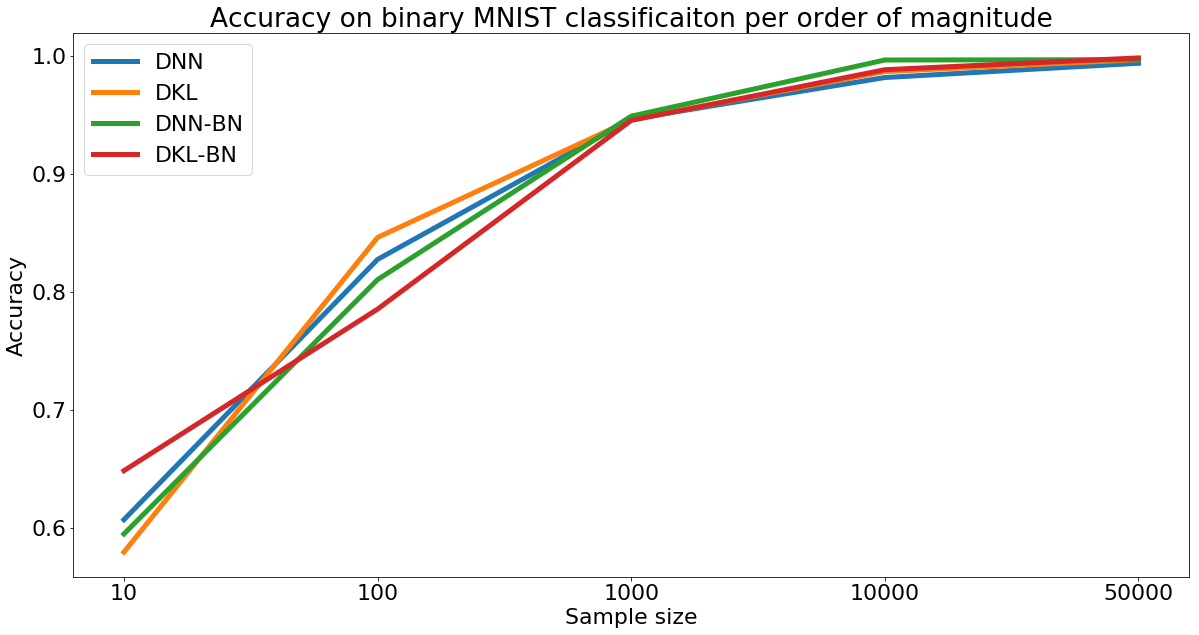

In [638]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

fig1, ax1 = plt.subplots()
ax1.plot(np.array([1, 2, 3, 4, 5], np.uint8), 1-final_results_dnn_no_bn, linewidth=5)
ax1.plot(np.array([1, 2, 3, 4, 5], np.uint8), 1-final_results_no_bn, linewidth=5)
ax1.plot(np.array([1, 2, 3, 4, 5], np.uint8), 1-final_results_dnn_bn, linewidth=5)
ax1.plot(np.array([1, 2, 3, 4, 5], np.uint8), 1-final_results_bn, linewidth=5)
ax1.legend(["DNN", "DKL", "DNN-BN","DKL-BN"])
ax1.set_xticks([1,2,3,4,5])
ax1.set_xticklabels(["10", "100", "1000", "10000", "50000"])
fig1.set_figheight(10)
fig1.set_figwidth(20)

plt.title("Accuracy on binary MNIST classificaiton per order of magnitude")
plt.xlabel("Sample size")
plt.ylabel("Accuracy")
plt.show()

In [17]:
print(final_results_bn)
print(final_results_no_bn)

[0.36000000000000004]
[0.5]


In [ ]:
results = []
for i in range(ntest//batch_size):
    X_s = X_test[M*i:(i+1)*M]
    preds = sess.run(m.predict_y(X), {X: X_s, phase: True})[0]
    actuals = Y_test[batch_size*i:(i+1)*batch_size,] % 2
    result = np.mean((preds.T - actuals)**2)
    results = results + [result]
np.mean(results)

In [ ]:
results = []
for i in range(ntest//batch_size):
    X_s = X_test[M*i:(i+1)*M]
    preds = sess.run(m.predict_y(X), {X: X_s, phase: True})[0]
    actuals = Y_test[batch_size*i:(i+1)*batch_size,] % 2
    result = np.mean((np.array([preds.T > 0.5]).astype(np.int8) - actuals)**2)
    results = results + [result]
np.mean(results)

In [ ]:
Y_dat2  =  np.expand_dims(Y_dat%2,1)
b = np.zeros((len(Y_dat), 2))
b[np.arange(len(Y_dat)), Y_dat%2] = 1
Y_dat2 = b

In [ ]:
tf.reset_default_graph()


# Batch size x time steps x features.

data = tf.placeholder(tf.float32, [batch_size, 784])
target = tf.placeholder(tf.float32, [batch_size, 2])
phase = tf.placeholder(tf.bool)


dropout = tf.placeholder(tf.float32)

def CNN(x_ph):
    x_ph = tf.reshape(x_ph, [-1,28, 28, 1])
    h = tf.layers.conv2d(x_ph, 32, 3, padding='same', activation=None, trainable=True)
    h = slim.batch_norm(h, center=True, scale=True, is_training=phase)
    h = tf.nn.relu(h)
#    h = tf.layers.dropout(h, drop, training=True)
    h = tf.layers.conv2d(h, 64, 3, padding='same', activation=None, trainable=True)
    h = slim.batch_norm(h, center=True, scale=True, is_training=phase)
    h = tf.nn.relu(h)
    h = tf.reshape(h, [M,-1])
    h = tf.layers.dense(h, 1024, activation=None, trainable=True)
    h = slim.batch_norm(h, center=True, scale=True, is_training=phase)
    h = tf.nn.relu(h)
    h = tf.layers.dense(h, 100, activation=None, trainable=True)
    h = slim.batch_norm(h, center=True, scale=True, is_training=phase)
    h = tf.nn.relu(h)
    h = tf.layers.dense(h, 2, activation=None, trainable=True)
    return h

logit = CNN(data)

prediction = tf.nn.softmax(logit)

loss = tf.losses.softmax_cross_entropy(target, logit)

opt = tf.train.AdamOptimizer()

train = opt.minimize(loss)

sess = tf.Session()

rng = npr.choice(ntrain,batch_size,replace=False)
data_batch = X_dat[rng, ].astype(np.float32)
target_batch = Y_dat2[rng, ].astype(np.float32) 

init_op = tf.global_variables_initializer()
sess.run(init_op)

init = sess.run(loss, {data: data_batch, target: target_batch, phase: True})
sess.run(train, {data: data_batch, target: target_batch, phase: True})
lik = sess.run(loss, {data: data_batch, target: target_batch, phase: True})

for i in range(num_iter):
    rng = npr.choice(ntrain,batch_size,replace=False)
    data_batch = X_dat[rng, ].astype(np.float32)
    target_batch = Y_dat2[rng, ].astype(np.float32) 
    sess.run(train, {data: data_batch, target: target_batch, phase: True})
    if i % (num_iter//10) == 0:
        init = lik
        lik = sess.run(loss, {data: data_batch, target: target_batch, phase: True})
        print(lik)

In [ ]:
ntest = 100
X_test, Y_test = mnist.train.next_batch(ntest)


In [ ]:
results = []
for i in range(ntest//batch_size):
    Xs = X_test[M*i:(i+1)*M]
    preds = sess.run(1/(1+tf.exp(-logit)),{data: Xs, phase: True})[:,1]
    actuals = Y_test[batch_size*i:(i+1)*batch_size,] % 2
    result = np.mean((preds - actuals)**2)
    results = results + [result]
np.mean(results)

In [ ]:
results = []
for i in range(ntest//batch_size):
    Xs = X_test[M*i:(i+1)*M]
    preds = sess.run(1/(1+tf.exp(-logit)),{data: Xs, phase: True})[:,1]
    actuals = Y_test[batch_size*i:(i+1)*batch_size,] % 2
    result = np.mean((np.array([preds > 0.5]).astype(np.int8) - actuals)**2)
    results = results + [result]
np.mean(results)

In [568]:
final_results_bn_batch_size_all_data = []

for j in range(7): 
    
    ntrain = 50000
    M = batch_size = 8*2**j
    ntest = 20*M
    tf.reset_default_graph()
    drop = tf.placeholder(tf.float64)
    phase = tf.placeholder(tf.bool)

    sess = tf.InteractiveSession()
    k = Deep(input_dim=784,nn=NN_BN)
    X_dat, Y_dat = mnist.train.next_batch(ntrain)
    X_test, Y_test = mnist.train.next_batch(ntest)
    Z = X_dat[0:M,]
    X = tf.placeholder(_settings.tf_float, [M,784])
    Y = tf.placeholder(_settings.tf_float, [M,1])

    with tf.variable_scope("kern"):
        xm = NN_BN(X)

    num_iter = 5000

    m = svgp.SVGP(X, Y,kern=k,
                       likelihood=likelihoods.Bernoulli(),Z=Z,minibatch_size=M)

    _iter = tf.placeholder(tf.int32, shape=None)

    decay = tf.maximum(0., 1.-(tf.cast(_iter, tf.float32)/(num_iter)))

    opt = tf.train.AdamOptimizer(0.001)
    lik = m._build_likelihood()
    train = opt.minimize(-lik)

    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    for i in range(num_iter):
        inds = np.random.choice(len(X_dat), M, replace=False)
        Xs = X_dat[inds,]
        Ys = Y_dat[inds,] % 2
        Ys = np.expand_dims(Ys, 1)
    #    print(np.min(sess.run(m.q_sqrt)))
    #    print(np.min(sess.run(m.Z)))
    #    print(np.min(sess.run(fvar, {X: X_dat, drop: 0.5})))
        sess.run(train, {Y: Ys, X: Xs, drop: 0.5, phase: True, _iter: i})
        if i % (num_iter//10) == 0:
            print(sess.run(lik, {Y: Ys, X: Xs, drop: 0.5, phase: True}))
        results = []
    for i in range(ntest//batch_size):
        rng = npr.choice(len(range(ntest)),batch_size,replace=False)
        Xs = X_test[rng, ].astype(np.float32)
        preds = sess.run(m.predict_y(X), {X: Xs, phase: True})[0]
        actuals = Y_test[rng,] % 2
        #result = np.mean((preds.T - actuals)**2)
        result = np.mean((np.array([preds.T > 0.5]).astype(np.int8) - actuals)**2)
        results = results + [result]
    
    final_results_bn_batch_size_all_data = final_results_bn_batch_size_all_data + [np.mean(results)]

-7.93755818231
-4.87852171967
-4.13163704013
-3.4290373323
-4.18412287917
-3.49129386426
-3.08384262561
-3.73458738144
-3.24416809957
-2.89484232902
-15.8640021855
-7.16416509491
-6.62293479232
-4.39627050397
-4.39122866476
-3.86658874535
-3.4482856742
-4.6355993526
-3.31788072844
-3.20184377663
-31.7326741663
-8.84844102444
-5.61958353575
-6.05237594274
-4.86578045939
-4.19734081194
-6.02369853802
-5.55674813464
-4.02035547539
-4.34926156069
-63.4556061818
-8.32274656468
-7.97202612599
-8.32998865707
-6.5082130976
-6.84291502582
-5.4857048875
-4.77106683781
-4.65121776504
-4.43966115643
-126.95053608
-16.4511780064
-9.8453103148
-8.39080085102
-7.23775265699
-7.28137815123
-5.79764380541
-5.60666593617
-5.24806837269
-5.39865735215
-253.773376681
-24.550227632
-15.7363387165
-9.53600911335
-8.31951629447
-7.48175334968
-6.54272063354
-6.12344172981
-5.71609292816
-7.16715995694
-507.78021681
-45.932414536
-16.2615314776
-12.2914260051
-10.74215227
-9.34175310169
-8.34431841364
-7.7603

In [ ]:
final_results_bn_batch_size_low_data = []

for j in range(7): 
    
    ntrain = 1000
    M = batch_size = 8*2**j
    ntest = 20*M
    tf.reset_default_graph()
    drop = tf.placeholder(tf.float64)
    phase = tf.placeholder(tf.bool)

    sess = tf.InteractiveSession()
    k = Deep(input_dim=784,nn=NN_BN)
    X_dat, Y_dat = mnist.train.next_batch(ntrain)
    X_test, Y_test = mnist.train.next_batch(ntest)
    Z = X_dat[0:M,]
    X = tf.placeholder(_settings.tf_float, [M,784])
    Y = tf.placeholder(_settings.tf_float, [M,1])

    with tf.variable_scope("kern"):
        xm = NN_BN(X)

    num_iter = 5000

    m = svgp.SVGP(X, Y,kern=k,
                       likelihood=likelihoods.Bernoulli(),Z=Z,minibatch_size=M)

    _iter = tf.placeholder(tf.int32, shape=None)

    decay = tf.maximum(0., 1.-(tf.cast(_iter, tf.float32)/(num_iter)))

    opt = tf.train.AdamOptimizer(0.001)
    lik = m._build_likelihood()
    train = opt.minimize(-lik)

    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    for i in range(num_iter):
        inds = np.random.choice(len(X_dat), M, replace=False)
        Xs = X_dat[inds,]
        Ys = Y_dat[inds,] % 2
        Ys = np.expand_dims(Ys, 1)
    #    print(np.min(sess.run(m.q_sqrt)))
    #    print(np.min(sess.run(m.Z)))
    #    print(np.min(sess.run(fvar, {X: X_dat, drop: 0.5})))
        sess.run(train, {Y: Ys, X: Xs, drop: 0.5, phase: True, _iter: i})
        if i % (num_iter//10) == 0:
            print(sess.run(lik, {Y: Ys, X: Xs, drop: 0.5, phase: True}))
        results = []
    for i in range(ntest//batch_size):
        rng = npr.choice(len(range(ntest)),batch_size,replace=False)
        Xs = X_test[rng, ].astype(np.float32)
        preds = sess.run(m.predict_y(X), {X: Xs, phase: True})[0]
        actuals = Y_test[rng,] % 2
        #result = np.mean((preds.T - actuals)**2)
        result = np.mean((np.array([preds.T > 0.5]).astype(np.int8) - actuals)**2)
        results = results + [result]
    
    final_results_bn_batch_size_low_data = final_results_bn_batch_size_low_data + [np.mean(results)]

-7.93553488141
-4.87384252064
-5.45596982267
-6.28493469436
-3.01946043263
-4.0926292098
-3.27465546893
-2.84564465755
-3.68052504648
-3.39087345205
-15.8682024191
-6.56906687758
-6.28651445318
-4.12695758382
-5.51258055993
-5.01252595674
-3.6462186437
-3.3081252079
-3.46141844691
-3.32352062259
-31.7329312595
-8.010666717
-5.90490627424
-5.59159638378
-5.09466510573
-4.31878277896
-4.66653160051
-4.01099905859
-5.07109688727
-3.7973529008
-63.463772577
-10.0274205591
-8.44065656102
-8.64145705767
-5.57506115562
-7.42471634319
-4.73652314903
-4.50147031395
-4.54833924762
-4.14506024017
-126.899469018
-11.5287772217
-7.2433187531
-6.41036706457
-5.96354329141
-5.52307756003
-5.35025000821
-4.79241461672
-5.57210071589
-4.35052766168
-253.85462474
-28.1440625781
-10.5731909804
-7.77851506073
-7.84928874626
-6.55722847221
-7.00324636386
-6.6772981395
-5.47481873318
-61.2427703067
-507.838715603
-34.0393441869
-20.8244157446
-18.6003916328
-16.0819972985
-15.4733617092
-15.1660807299
-14.0

In [645]:
final_results_bn_batch_size_low_data

[0.018749999999999999,
 0.0093749999999999997,
 0.0031250000000000002,
 0.0046874999999999998,
 0.039843749999999997,
 0.047070312500000003,
 0.060742187500000003]

In [648]:
final_results_bn_batch_size

[0.025000000000000001,
 0.015625,
 0.012500000000000001,
 0.0023437499999999999,
 0.0,
 0.0,
 0.0]

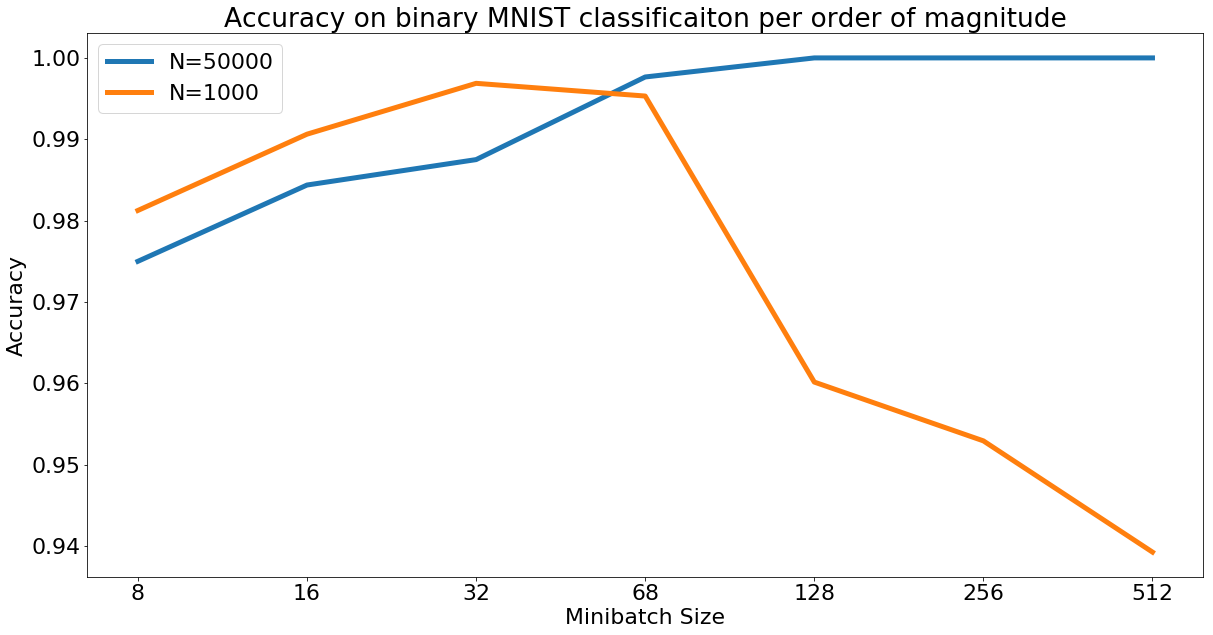

In [649]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

fig1, ax1 = plt.subplots()
ax1.plot(np.array([1, 2, 3, 4, 5,6,7], np.uint8), 1-np.array(final_results_bn_batch_size), linewidth=5)
ax1.plot(np.array([1, 2, 3, 4, 5,6,7], np.uint8), 1-np.array(final_results_bn_batch_size_low_data), linewidth=5)
ax1.legend(["N=50000", "N=1000"])
ax1.set_xticks([1,2,3,4,5,6,7])
ax1.set_xticklabels(["8", "16", "32", "68", "128","256","512"])
fig1.set_figheight(10)
fig1.set_figwidth(20)

plt.title("Accuracy on binary MNIST classificaiton per order of magnitude")
plt.xlabel("Minibatch Size")
plt.ylabel("Accuracy")
plt.show()

In [643]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

fig1, ax1 = plt.subplots()

ax1.plot(np.array([1, 2, 3, 4, 5,6,7], np.uint8), 1-np.array(final_results_bn_batch_size_all_data), linewidth=5)
ax1.plot(np.array([1, 2, 3, 4, 5,6,7], np.uint8), 1-np.array(final_results_bn_batch_size_no_data), linewidth=5)
ax1.legend(["N=50000", "N=1000"])
ax1.set_xticks([1,2,3,4,5,6,7])
ax1.set_xticklabels(["8", "16", "32", "68", "128","256","512"])
fig1.set_figheight(10)
fig1.set_figwidth(20)

plt.title("Accuracy on binary MNIST classificaiton per order of magnitude")
plt.xlabel("Minibatch Size")
plt.ylabel("Accuracy")
plt.show()

NameError: name 'final_results_bn_batch_size_all_data' is not defined